# GC ボット用 過去データ取得ノートブック
`fetch_ohlcv_range_ccxt` を使って指定期間の OHLCV を取得し、Parquet/CSV に保存します。

## 使い方
1. 取得したい期間 (`start_jst`, `end_jst`) または `days` を設定します。
2. 実行すると DataFrame をプレビューし、指定のパスに保存します。

In [1]:
from datetime import datetime, timedelta
from pathlib import Path

import pandas as pd

from gc_bot import CCXTConfig, fetch_ohlcv_range_ccxt, load_env_settings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

from gc_bot.strategies import compute_rsi


In [2]:
# 取得設定
exchange_id = "binance"
symbol = "XRP/JPY"
timeframe = "5m"
days = 30  # start/end を明示する代わりに過去何日さかのぼるかを指定
start_jst = None  # 例: pd.Timestamp('2023-01-01 00:00', tz='Asia/Tokyo')
end_jst = None    # 例: pd.Timestamp('2024-01-01 00:00', tz='Asia/Tokyo')
chunk_limit = 200
output_parquet = Path("../data/candles/xrpjpy_5m_history.parquet")
output_csv = Path("../data/candles/xrpjpy_5m_history.csv")


In [3]:
# 1. 環境変数をロード (API キーなどを .env から読み込む場合)
load_env_settings()

# 2. 期間を決定
if end_jst is None:
    end_jst = pd.Timestamp.now(tz="Asia/Tokyo")
if start_jst is None:
    start_jst = end_jst - pd.Timedelta(days=days)

print(f"Fetching {symbol} {timeframe} candles from {start_jst} to {end_jst}")
cfg = CCXTConfig(exchange_id=exchange_id, symbol=symbol, timeframe=timeframe, limit=chunk_limit)

df_history = fetch_ohlcv_range_ccxt(
    cfg,
    start=start_jst,
    end=end_jst,
    chunk_limit=chunk_limit,
    progress=True,
)
df_history.head()


Fetching XRP/JPY 5m candles from 2025-09-12 17:35:32.196938+09:00 to 2025-10-12 17:35:32.196938+09:00


,open_time_jst,open,high,low,close,volume,open_time_utc,close_time_utc,timestamp_ms
close_time_jst,,,,,,,,,
2025-09-12 17:40:00+09:00,2025-09-12 16:40:00+09:00,452.52,452.52,451.95,452.11,1922.9,2025-09-12 07:40:00+00:00,2025-09-12 08:40:00+00:00,1757666400000
2025-09-12 17:45:00+09:00,2025-09-12 16:45:00+09:00,452.11,452.16,451.89,452.12,1835.1,2025-09-12 07:45:00+00:00,2025-09-12 08:45:00+00:00,1757666700000
2025-09-12 17:50:00+09:00,2025-09-12 16:50:00+09:00,452.16,452.44,452.15,452.33,1085.6,2025-09-12 07:50:00+00:00,2025-09-12 08:50:00+00:00,1757667000000
2025-09-12 17:55:00+09:00,2025-09-12 16:55:00+09:00,452.40,452.87,452.36,452.61,2006.2,2025-09-12 07:55:00+00:00,2025-09-12 08:55:00+00:00,1757667300000
2025-09-12 18:00:00+09:00,2025-09-12 17:00:00+09:00,452.74,453.04,451.93,452.04,7524.4,2025-09-12 08:00:00+00:00,2025-09-12 09:00:00+00:00,1757667600000


In [4]:
# 3. 保存
output_parquet.parent.mkdir(parents=True, exist_ok=True)
df_history.to_parquet(output_parquet, index=True)
print(f"Parquet saved to {output_parquet}")

if output_csv:
    output_csv.parent.mkdir(parents=True, exist_ok=True)
    df_history.to_csv(output_csv, index=True, encoding="utf-8")
    print(f"CSV saved to {output_csv}")


Parquet saved to ../data/candles/xrpjpy_5m_history.parquet
CSV saved to ../data/candles/xrpjpy_5m_history.csv


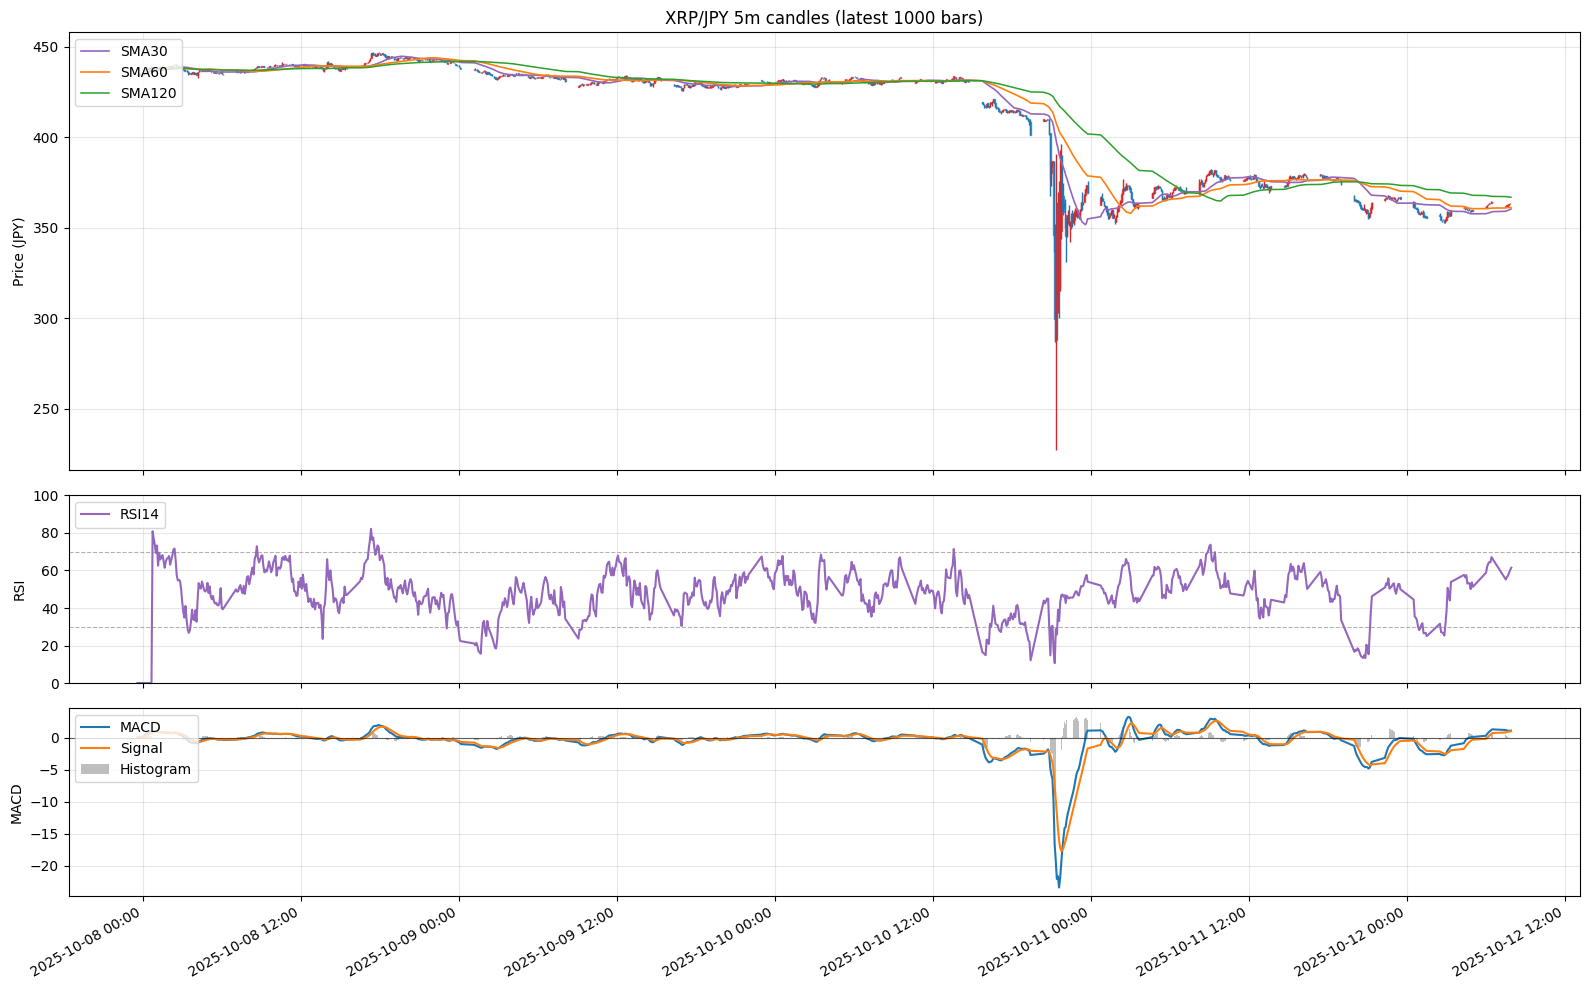

In [5]:
# 4. 取得データの可視化 (ローソク足 + SMA + RSI + MACD)
if 'df_history' not in globals():
    raise ValueError('df_history is not defined; run the fetch cell first')

if df_history.empty:
    raise ValueError('df_history is empty; fetch returned no rows')

plot_df = df_history.tail(1000).copy()
if plot_df.index.tz is None:
    plot_df.index = pd.to_datetime(plot_df.index).tz_localize('Asia/Tokyo')
else:
    plot_df.index = plot_df.index.tz_convert('Asia/Tokyo')

plot_df['sma30'] = plot_df['close'].rolling(window=30, min_periods=1).mean()
plot_df['sma60'] = plot_df['close'].rolling(window=60, min_periods=1).mean()
plot_df['sma120'] = plot_df['close'].rolling(window=120, min_periods=1).mean()
plot_df['rsi14'] = compute_rsi(plot_df['close'], period=14)

def ema(series, span):
    return series.ewm(span=span, adjust=False).mean()

ema12 = ema(plot_df['close'], span=12)
ema26 = ema(plot_df['close'], span=26)
plot_df['macd'] = ema12 - ema26
plot_df['macd_signal'] = plot_df['macd'].ewm(span=9, adjust=False).mean()
plot_df['macd_hist'] = plot_df['macd'] - plot_df['macd_signal']

if plot_df[['open', 'high', 'low', 'close']].isnull().any().any():
    raise ValueError('price columns contain NaN; please inspect the fetched data')

fig, (ax_price, ax_rsi, ax_macd) = plt.subplots(
    3,
    1,
    figsize=(16, 10),
    sharex=False,
    gridspec_kw={"height_ratios": [3.5, 1.5, 1.5]},
)

dates = plot_df.index
date_nums = mdates.date2num(dates.to_pydatetime())
if len(dates) > 1:
    step_days = (dates[1] - dates[0]).total_seconds() / 86400.0
else:
    step_days = 1 / 24
bar_width = step_days * 0.6

for dnum, (_, row) in zip(date_nums, plot_df.iterrows()):
    o, h, l, c = row['open'], row['high'], row['low'], row['close']
    color = 'tab:red' if c >= o else 'tab:blue'
    ax_price.vlines(dnum, l, h, color=color, linewidth=1)
    body_bottom = min(o, c)
    body_height = max(abs(c - o), 1e-6)
    ax_price.add_patch(
        Rectangle(
            (dnum - bar_width / 2, body_bottom),
            bar_width,
            body_height,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
    )

ax_price.plot(date_nums, plot_df['sma30'], label='SMA30', color='tab:purple', linewidth=1.2)
ax_price.plot(date_nums, plot_df['sma60'], label='SMA60', color='tab:orange', linewidth=1.2)
ax_price.plot(date_nums, plot_df['sma120'], label='SMA120', color='tab:green', linewidth=1.1)
ax_price.set_ylabel('Price (JPY)')
ax_price.set_title(f"{symbol} {timeframe} candles (latest {len(plot_df)} bars)")
ax_price.grid(alpha=0.3)
ax_price.legend(loc='upper left')
ax_price.xaxis_date()
ax_price.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

ax_rsi.plot(date_nums, plot_df['rsi14'], color='tab:purple', label='RSI14')
ax_rsi.set_ylim(0, 100)
ax_rsi.set_ylabel('RSI')
ax_rsi.axhline(70, color='grey', linestyle='--', linewidth=0.8, alpha=0.6)
ax_rsi.axhline(30, color='grey', linestyle='--', linewidth=0.8, alpha=0.6)
ax_rsi.legend(loc='upper left')
ax_rsi.grid(alpha=0.3)
ax_rsi.xaxis_date()
ax_rsi.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

ax_macd.plot(date_nums, plot_df['macd'], color='tab:blue', label='MACD')
ax_macd.plot(date_nums, plot_df['macd_signal'], color='tab:orange', label='Signal')
ax_macd.bar(date_nums, plot_df['macd_hist'], width=bar_width * 0.9, color='tab:grey', alpha=0.5, label='Histogram')
ax_macd.set_ylabel('MACD')
ax_macd.axhline(0, color='black', linewidth=0.8, alpha=0.6)
ax_macd.legend(loc='upper left')
ax_macd.grid(alpha=0.3)
ax_macd.xaxis_date()
ax_macd.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

